# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:



Then you will want to run the above command:



Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Overview of the Project

##  Load Library

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import datetime
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

%matplotlib inline

## Load Data

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Cleansing and Exploratory Data

**1. Portfolio Dataset**

In [3]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [4]:
print('Total number of Row: {} and Column: {}'.format(portfolio.shape[0], portfolio.shape[1]))

Total number of Row: 10 and Column: 6


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [6]:
def preparation_data_portfolio(portfolio):
    '''
    preparation data portfolio
    
    Input:
    portfolio - the portfolio dataframe to be prepared
    
    Return:
    portfolio - the prepared portfolio dataframe
    
    '''
    # creating a copy from the dataset
    pre_portfolio = portfolio.copy()
    
    # changing duration column from days to hours
    pre_portfolio['duration'] = pre_portfolio['duration']*24
    
    # renaming duration column to duration_hours
    pre_portfolio.rename(columns={'duration':'duration_hours'},inplace=True)
    
    # renaming id column to offer_id
    pre_portfolio.rename(columns={'id':'offer_id'},inplace=True)
         
    # creating one hot encoding from the channels column 
    pre_portfolio['channel_email'] = pre_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    pre_portfolio['channel_mobile'] = pre_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    pre_portfolio['channel_social'] = pre_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    pre_portfolio['channel_web'] = pre_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
    # dropping the channels column
    pre_portfolio.drop('channels', axis=1, inplace=True)
    
    return pre_portfolio

In [7]:
pre_portfolio = preparation_data_portfolio(portfolio)

In [8]:
pre_portfolio.head()

,reward,difficulty,duration_hours,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [9]:
# replacing the offer_id by more easy ids
offer_id = pre_portfolio['offer_id'].astype('category').cat.categories.tolist()
replace_offer_id = {'offer_id' : {k: v for k,v in zip(offer_id,list(range(1,len(offer_id)+1)))}}

# replacing the categorical values in the offer_id column by numberical values
pre_portfolio.replace(replace_offer_id, inplace=True)

In [10]:
def cleaned_portfolio(pre_portfolio):
    '''
    cleaning data  portfolio 
    
    Input:
    portfolio - the portfolio dataframe to be cleaned
    
    Return:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler() # default=(0, 1)
    numerical = ['difficulty','reward']

    #features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
    pre_portfolio[numerical] = scaler.fit_transform(pre_portfolio[numerical])
    
    # replacing offer_type by integers representing each offer type
    offer_type = pre_portfolio['offer_type'].astype('category').cat.categories.tolist()
    replace_offer_type = {'offer_type' : {k: v for k,v in zip(offer_type,list(range(1,len(offer_type)+1)))}}

    # replacing the categorical values in offer_type column by numberical values
    pre_portfolio.replace(replace_offer_type, inplace=True)
    
    return pre_portfolio

In [11]:
cleaned_portfolio = cleaned_portfolio(pre_portfolio)

In [12]:
cleaned_portfolio.head()

,reward,difficulty,duration_hours,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,1.0,0.50,168,1,8,1,1,1,0
1,1.0,0.50,120,1,5,1,1,1,1
2,0.0,0.00,96,3,4,1,1,0,1
3,0.5,0.25,168,1,7,1,1,0,1
4,0.5,1.00,240,2,1,1,0,0,1


In [13]:
cleaned_portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reward          10 non-null     float64
 1   difficulty      10 non-null     float64
 2   duration_hours  10 non-null     int64  
 3   offer_type      10 non-null     int64  
 4   offer_id        10 non-null     int64  
 5   channel_email   10 non-null     int64  
 6   channel_mobile  10 non-null     int64  
 7   channel_social  10 non-null     int64  
 8   channel_web     10 non-null     int64  
dtypes: float64(2), int64(7)
memory usage: 848.0 bytes


**2. Profile Dataset**

In [14]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [15]:
print('Total number of Row: {} and Column: {}'.format(profile.shape[0], profile.shape[1]))

Total number of Row: 17000 and Column: 5


In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [17]:
profile.isna().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [18]:
(profile.age == 118).sum()

2175

In [19]:
def preparation_data_profile(profile):
    '''
    preparation data profile
    
    Input:
    profile - the profile dataframe to be prepared
    
    Return:
    profile - the prepared profile dataframe
    
    '''
    # creating a copy from the dataset
    pre_profile = profile.copy()

    # renaming id column name to customer_id
    pre_profile.rename(columns={'id':'customer_id'},inplace=True)
    
    # reindexing some columns
    pre_profile = pre_profile.reindex(columns=['customer_id', 'age', 'became_member_on', 'gender', 'income'])

    # age: (numeric) missing value encoded as 118
    pre_profile['age'] = pre_profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    pre_profile.dropna(inplace=True)
    
    # changing the datatype of age and income columns to integer
    pre_profile[['age','income']] = pre_profile[['age','income']].astype(int)    
    
    return pre_profile

In [20]:
pre_profile = preparation_data_profile(profile)

In [21]:
pre_profile.head()

,customer_id,age,became_member_on,gender,income
1,0610b486422d4921ae7d2bf64640c50b,55,20170715,F,112000
3,78afa995795e4d85b5d9ceeca43f5fef,75,20170509,F,100000
5,e2127556f4f64592b11af22de27a7932,68,20180426,M,70000
8,389bc3fa690240e798340f5a15918d5c,65,20180209,M,53000
12,2eeac8d8feae4a8cad5a6af0499a211d,58,20171111,M,51000


Text(0.5, 1.0, 'Age Distribution')

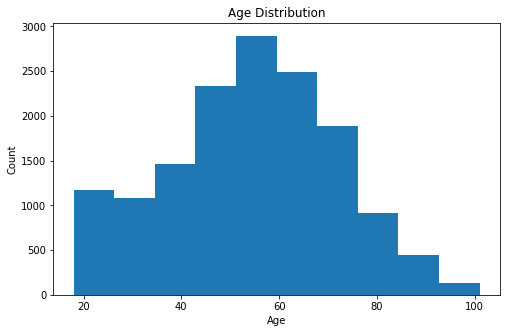

In [22]:
# plot a age distribution in data
fig, ax = plt.subplots(figsize=(8, 5))
plt.sca(ax)
plt.hist(pre_profile['age'], bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

Based on age distribution plot, shows that the median age of customers is 55 and the number of cutomers with age above 55 tends to decrease.

Text(0.5, 1.0, 'Income Customers Distribution')

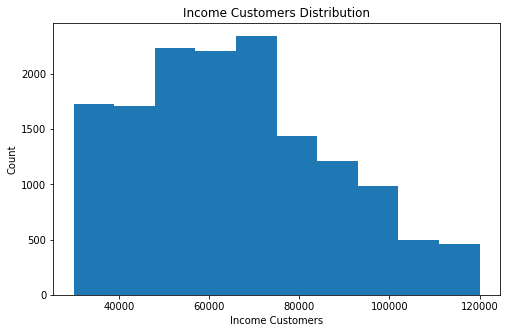

In [23]:
# plot a income customers distribution in data
fig, ax = plt.subplots(figsize=(8, 5))
plt.sca(ax)
plt.hist(pre_profile['income'])
plt.xlabel('Income Customers')
plt.ylabel('Count')
plt.title('Income Customers Distribution')

Based on the income distribution plot of customers, it shows that income customers have the highest average value around 50000–75000.

In [24]:
# checking the number of gender customers 
pre_profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

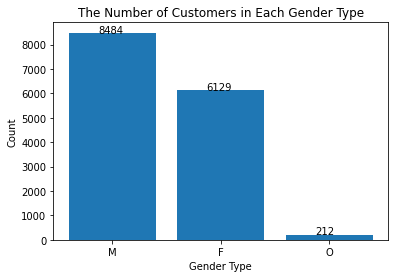

In [25]:
profile_gender = pre_profile.gender.value_counts()
x = ['M','F','O']
data = profile_gender
plt.bar(x,height = data);
xlocs, xlabs = plt.xticks()
for i, v in enumerate(data):
    plt.text(xlocs[i] - 0.13, v , str(v))
plt.xlabel('Gender Type');
plt.ylabel('Count');
plt.title('The Number of Customers in Each Gender Type');

Based on the number of costomers in each gender type, it shows that there are more male customers than female customers and others. Customer with male gender has 8484, female has 6129 and other has 212.

In [26]:
pre_profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [27]:
def cleaned_profile(pre_profile):
    '''
    cleaning data profile 
    
    Input:
    profile - the profile dataframe to be cleaned
    
    Return:
    profile - the cleaned profile dataframe
    
    '''
    # creating a new column representing the age group to which the customer belongs 
    pre_profile['age_group'] = pd.cut(pre_profile['age'], bins=[17, 22, 35, 60, 102],labels=['teenager', 'young-adult', 'adult', 'elderly'])

    # replacing the age_group categorical labels by numerical labels
    age_group = pre_profile['age_group'].astype('category').cat.categories.tolist()
    replace_age_group = {'age_group' : {k: v for k,v in zip(age_group,list(range(1,len(age_group)+1)))}}

    # replacing categorical labels in age_group column with numerical labels
    pre_profile.replace(replace_age_group, inplace=True)

    # creating a new column representing the income group to which the customer belongs 
    pre_profile['income_customer'] = pd.cut(pre_profile['income'], bins=[29999, 64000, 120100],labels=['below-average', 'above-average'])

    # replacing the income_customer categorical labels by numerical labels
    income_range = pre_profile['income_customer'].astype('category').cat.categories.tolist()
    replace_income_range = {'income_customer' : {k: v for k,v in zip(income_range,list(range(1,len(income_range)+1)))}}

    # replacing categorical labels in income_customer column with numerical labels
    pre_profile.replace(replace_income_range, inplace=True)

    # replacing the gender categorical labels with coressponding numerical label
    gender = pre_profile['gender'].astype('category').cat.categories.tolist()
    replace_gender = {'gender' : {k: v for k,v in zip(gender,list(range(1,len(gender)+1)))}}
    
    # replacing categorical labels in gender column with numerical labels
    pre_profile.replace(replace_gender, inplace=True)
    
    # formating became_member_on column to datetime
    pre_profile['became_member_on'] = pd.to_datetime(pre_profile['became_member_on'], format='%Y%m%d')
   
    # creating start_year and start_month columns from became_member_on column
    pre_profile['start_year'] = pre_profile.became_member_on.dt.year
    pre_profile['start_month'] = pre_profile.became_member_on.dt.month

    # dropping age and income columns
    pre_profile.drop(columns = ['age','income'], axis=1, inplace=True)
    
    return pre_profile

In [28]:
cleaned_profile = cleaned_profile(pre_profile)

In [29]:
cleaned_profile.head()

,customer_id,became_member_on,gender,age_group,income_customer,start_year,start_month
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,1,3,2,2017,7
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1,4,2,2017,5
5,e2127556f4f64592b11af22de27a7932,2018-04-26,2,4,2,2018,4
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,2,4,1,2018,2
12,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,2,3,1,2017,11


In [30]:
cleaned_profile['income_group'] = cleaned_profile['income_customer'].map({1: 'below-average', 2:'above-average'})

In [31]:
cleaned_profile.head()

,customer_id,became_member_on,gender,age_group,income_customer,start_year,start_month,income_group
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,1,3,2,2017,7,above-average
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,1,4,2,2017,5,above-average
5,e2127556f4f64592b11af22de27a7932,2018-04-26,2,4,2,2018,4,above-average
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,2,4,1,2018,2,below-average
12,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,2,3,1,2017,11,below-average


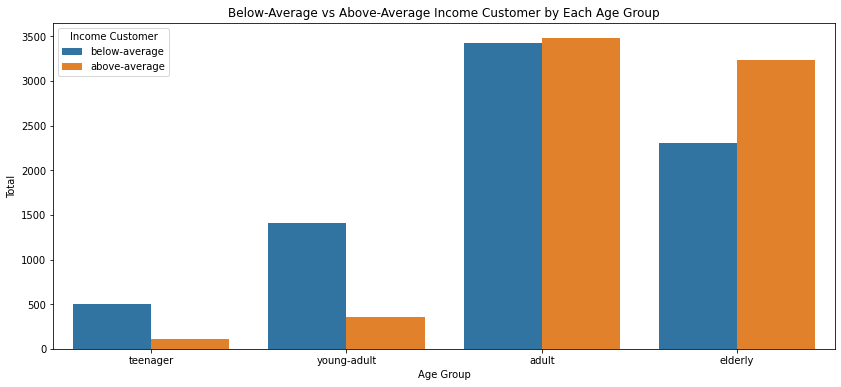

In [32]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="age_group", hue="income_group", data=cleaned_profile)
plt.title('Below-Average vs Above-Average Income Customer by Each Age Group')
plt.ylabel('Total')
plt.xlabel('Age Group')
xlabels = ['teenager','young-adult','adult','elderly']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Income Customer')
plt.show();

Teeneger and young-adult customers who have below-average income are more than customers with above-average income, whereas adult and elderly customers who have above-average income are more than customers with below-average income.
The number of adult customers is more than teenagers, young adults and elderly customers.

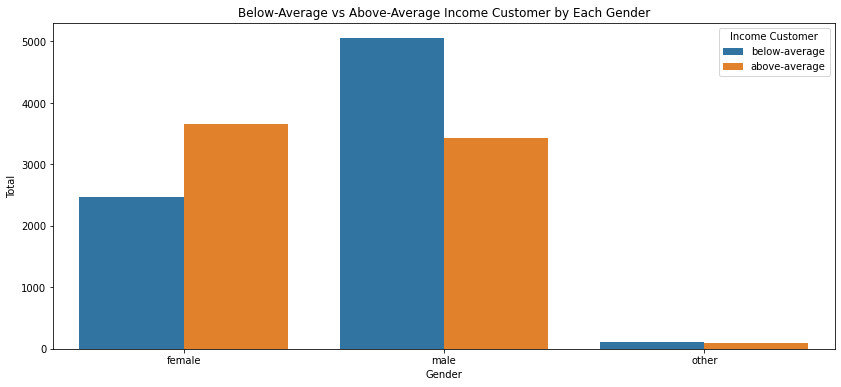

In [33]:
plt.figure(figsize=(14, 6))
g = sns.countplot(x="gender", hue="income_group", data=cleaned_profile)
plt.title('Below-Average vs Above-Average Income Customer by Each Gender')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['female','male','other']
g.set_xticklabels(xlabels)
plt.xticks(rotation = 0)
plt.legend(title='Income Customer')
plt.show();

Female customers with above-average income more than below-average, whereas male customers with below-average income more than above-average.

**3. Transcript Dataset**

In [34]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [35]:
print('Total number of Row: {} and Column: {}'.format(transcript.shape[0], transcript.shape[1]))

Total number of Row: 306534 and Column: 4


In [36]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [37]:
transcript.isna().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [38]:
def preparation_data_transcript(transcript):
    '''
    preparation data transcript 
    
    Input:
    transcript - the transcript dataframe to be prepared
    
    Return:
    transcript - the prepared transcript dataframe   
    
    '''
    # create a copy from the dataset
    pre_transcript = transcript.copy()
    
    # renaming time column to time_hours
    pre_transcript.rename(columns={'time':'time_hours'},inplace=True)
    
    # renaming person column to customer_id
    pre_transcript.rename(columns={'person':'customer_id'},inplace=True)  
    
    return pre_transcript

In [39]:
pre_transcript = preparation_data_transcript(transcript)

In [40]:
pre_transcript.head()

,customer_id,event,value,time_hours
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [41]:
# extracting each key that exist in value column to a seperate column.
keys = []
for idx, row in pre_transcript.iterrows():
    for key in row['value']:
        if key in keys:
            continue
        else:
            keys.append(key)

In [42]:
# creating columns and specify the datatype of each of them
pre_transcript['offer_id'] = '' # string
pre_transcript['amount'] = 0    # integer
pre_transcript['reward'] = 0    # integer

In [43]:
# Iterating over pre_transcript dataset
for idx, row in pre_transcript.iterrows():
    for key in row['value']:
        if key == 'offer_id' or key == 'offer id': # b/c 'offer_id' and 'offer id' are representing the same thing 
            pre_transcript.at[idx, 'offer_id'] = row['value'][key]
        if key == 'amount':
            pre_transcript.at[idx, 'amount'] = row['value'][key]
        if key == 'reward':
            pre_transcript.at[idx, 'reward'] = row['value'][key]

In [44]:
keys

['offer id', 'amount', 'offer_id', 'reward']

In [45]:
pre_transcript.head()

,customer_id,event,value,time_hours,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0


In [46]:
# filling all the NaNs in the offer_id column with 'N/A' values (i.e. Not Applicable)
pre_transcript['offer_id'] = pre_transcript['offer_id'].apply(lambda x: 'N/A' if x == '' else x)

In [47]:
# replacing the categorical values in the offer_id column by its corresponding numerical values
pre_transcript.replace(replace_offer_id, inplace=True)

In [48]:
pre_transcript.head()

,customer_id,event,value,time_hours,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,7,0.0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0.0,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,3,0.0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,10,0.0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,5,0.0,0


In [49]:
pre_transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [50]:
def cleaned_transcript(pre_transcript):
    '''
    cleaning data transcript 
    
    Input:
    transcript - the transcript dataframe to be cleaned
    
    Return:
    transcript - the cleaned transcript dataframe
    
    '''    
    # dropping the value column 
    pre_transcript.drop('value', axis=1, inplace=True)

    # excluding all events of 'transaction' from our clean_transcript dataset
    pre_transcript = pre_transcript[pre_transcript['event'] != 'transaction']

    # excluding all events of 'offer received' 
    pre_transcript = pre_transcript[pre_transcript['event'] != 'offer received']

    # replacing the 'event' categorical labels with coressponding numerical label
    labels_event = pre_transcript['event'].astype('category').cat.categories.tolist()
    replace_map_comp_event = {'event' : {k: v for k,v in zip(labels_event,list(range(1,len(labels_event)+1)))}}

    # replacing categorical labels in 'event' column with numerical labels
    pre_transcript.replace(replace_map_comp_event, inplace=True)
    
    return pre_transcript

In [51]:
cleaned_transcript = cleaned_transcript(pre_transcript)

In [52]:
cleaned_transcript.head()

,customer_id,event,time_hours,offer_id,amount,reward
12650,389bc3fa690240e798340f5a15918d5c,2,0,9,0.0,0
12651,d1ede868e29245ea91818a903fec04c6,2,0,6,0.0,0
12652,102e9454054946fda62242d2e176fdce,2,0,5,0.0,0
12653,02c083884c7d45b39cc68e1314fec56c,2,0,8,0.0,0
12655,be8a5d1981a2458d90b255ddc7e0d174,2,0,6,0.0,0


In [53]:
cleaned_transcript.event.unique()

array([2, 1], dtype=int64)

## Merge Data

In [54]:
def merge_data(cleaned_transcript, cleaned_portfolio, cleaned_profile):
    
    # merge 'clean_transcript' dataset with 'clean_portfolio' on 'offer_id'
    master_df =cleaned_transcript.merge(cleaned_portfolio,how='left',on='offer_id')
    
    # join 'master_df' dataset with 'clean_profile' on 'customer_id'
    master_df = master_df.merge(cleaned_profile,how ='left', on = 'customer_id')

    # removing any row that contain NaNs
    master_df = master_df.dropna(how='any',axis=0)
    
    return master_df

In [55]:
master_df = merge_data(cleaned_transcript, cleaned_portfolio, cleaned_profile)

In [56]:
master_df.head()

,customer_id,event,time_hours,offer_id,amount,reward_x,reward_y,difficulty,duration_hours,offer_type,...,channel_mobile,channel_social,channel_web,became_member_on,gender,age_group,income_customer,start_year,start_month,income_group
0,389bc3fa690240e798340f5a15918d5c,2,0,9,0.0,0,0.5,0.25,120,1,...,1,1,1,2018-02-09,2.0,4,1,2018.0,2.0,below-average
1,d1ede868e29245ea91818a903fec04c6,2,0,6,0.0,0,0.0,0.00,72,3,...,1,1,0,2017-09-16,3.0,3,1,2017.0,9.0,below-average
2,102e9454054946fda62242d2e176fdce,2,0,5,0.0,0,1.0,0.50,120,1,...,1,1,1,2016-08-14,1.0,4,1,2016.0,8.0,below-average
3,02c083884c7d45b39cc68e1314fec56c,2,0,8,0.0,0,1.0,0.50,168,1,...,1,1,0,2016-07-11,1.0,1,1,2016.0,7.0,below-average
4,be8a5d1981a2458d90b255ddc7e0d174,2,0,6,0.0,0,0.0,0.00,72,3,...,1,1,0,2014-05-27,2.0,3,1,2014.0,5.0,below-average


In [57]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82304 entries, 0 to 91303
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       82304 non-null  object        
 1   event             82304 non-null  int64         
 2   time_hours        82304 non-null  int64         
 3   offer_id          82304 non-null  object        
 4   amount            82304 non-null  float64       
 5   reward_x          82304 non-null  int64         
 6   reward_y          82304 non-null  float64       
 7   difficulty        82304 non-null  float64       
 8   duration_hours    82304 non-null  int64         
 9   offer_type        82304 non-null  int64         
 10  channel_email     82304 non-null  int64         
 11  channel_mobile    82304 non-null  int64         
 12  channel_social    82304 non-null  int64         
 13  channel_web       82304 non-null  int64         
 14  became_member_on  8230

In [58]:
# Rename 'reward_x' column to 'reward'
master_df.rename(columns ={'reward_x':'reward'}, inplace = True)

## Model Building and Evaluating the Models

In [59]:
# Split the data into features and target label
X = master_df[['event', 'time_hours','offer_id','amount', 'reward', 'difficulty','gender','age_group']]
y = np.array(master_df['income_customer'])

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [61]:
def model_evaluation(classifier):
    cm = confusion_matrix(y_test, classifier.predict(X_test))
    counts = [value for value in cm.flatten()]
    labels = [f'{v1}' for v1 in counts]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot = labels, cmap = 'Greens', fmt = '')
    y_pred = classifier.predict(X_test)
    yt_pred = classifier.predict(X_train)
    print('The Training Accuracy of the algorithm is ', accuracy_score(y_train, yt_pred))
    print('The Testing Accuracy of the algorithm is ', accuracy_score(y_test, y_pred))
    print('--------'*8)
    print('The Training F1 Score of the algorithm is ', f1_score(y_train, yt_pred))
    print('The Testing F1 Score of the algorithm is ', f1_score(y_test, y_pred))
    
    return 

The Training Accuracy of the algorithm is  0.6263625633548566
The Testing Accuracy of the algorithm is  0.6141665316701765
----------------------------------------------------------------
The Training F1 Score of the algorithm is  0.5829910887253004
The Testing F1 Score of the algorithm is  0.5680344593062797


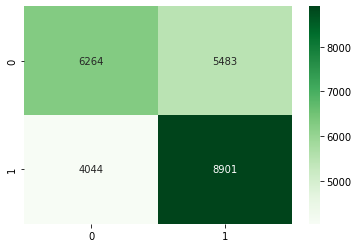

In [62]:
dt = DecisionTreeClassifier(max_depth = 5)
dt.fit(X_train, y_train)
model_evaluation(dt)

The Training Accuracy of the algorithm is  0.6282718878011525
The Testing Accuracy of the algorithm is  0.6178519358496679
----------------------------------------------------------------
The Training F1 Score of the algorithm is  0.575786387766421
The Testing F1 Score of the algorithm is  0.5632694621864297


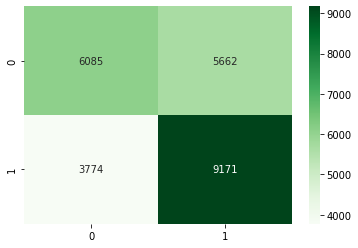

In [65]:
rf = RandomForestClassifier(max_depth = 5)
rf.fit(X_train, y_train)
model_evaluation(rf)

The Training Accuracy of the algorithm is  0.6619107130458932
The Testing Accuracy of the algorithm is  0.5619633889518872
----------------------------------------------------------------
The Training F1 Score of the algorithm is  0.6341335136556595
The Testing F1 Score of the algorithm is  0.5228936921041024


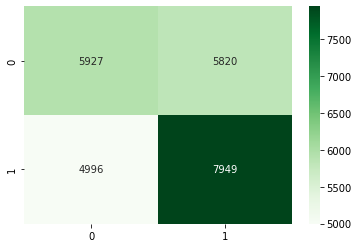

In [66]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
model_evaluation(knn)

## Conclusion

In this project I do several things such as cleaning data, exploratory data, combine data, build models and evaluating models.
Cleaning data is quite complicated in this project because there are data columns that must be separated into several data columns. 

There are a few things I did to make machine learning models such as remove data that has empty values, and change some data types to make it easier to create models. In data exploration, I only focus on things related to customer income.
In the section on making machine learning models, by comparing several models such as Decision Tree Classifier, Random Forest Classifier and KNeighbors Classifier. The results of these predictions Decision Tree Classifier has better accuracy and F1 scores than Random Forest Classifier and KNeighbors Classifier. 

Decision Tree Classifier has training and testing accuracy: 0.622 and 0.623 and training and testing F1 score: 0.593 and 0.597.
However, this model does not yet have an optimal accuracy and F1 score. We should do improvement or try another model that has accuracy and the F1 score is higher than this model.

## Improvements
For the improvement we can try XGBoost, Logistic Regression, LightGBM or another models. 
We have to explore the data more deeply to get good insights and do better data cleaning and preparation that can help us to make optimal machine learning models.